# Stage 1: Speech Emotion Recognition using CNN (Basic Version)

# 🧠 Goal

Predict emotions (happy, sad, angry, etc.) from speech using CNN on Mel Spectrograms.

# About Dataset

Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)
Speech audio-only files (16bit, 48kHz .wav) from the RAVDESS. Full dataset of speech and song, audio and video (24.8 GB) available from Zenodo. Construction and perceptual validation of the RAVDESS is described in our Open Access paper in PLoS ONE.

Check out our Kaggle Song emotion dataset.

Files

This portion of the RAVDESS contains 1440 files: 60 trials per actor x 24 actors = 1440. The RAVDESS contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech emotions includes calm, happy, sad, angry, fearful, surprise, and disgust expressions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.

File naming convention

Each of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics:

Filename identifiers

- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

-Vocal channel (01 = speech, 02 = song).

- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

- Repetition (01 = 1st repetition, 02 = 2nd repetition).

- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

- Filename example: 03-01-06-01-02-01-12.wav

- Audio-only (03)
Speech (01)
Fearful (06)
Normal intensity (01)
Statement "dogs" (02)
1st Repetition (01)
12th Actor (12)
Female, as the actor ID number is even.

In [85]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'ravdess-emotional-speech-audio' dataset.
Path to dataset files: /kaggle/input/ravdess-emotional-speech-audio


In [86]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [87]:
file_path = os.path.join(path + '/Actor_02' + '/03-01-07-02-01-02-02.wav')

In [88]:
DATA_PATH = path  # path where your audio folders are

labels = []
features = []
y = []

for subdir, _, files in os.walk(DATA_PATH):
    for file in files:
        if file.endswith(".wav"):
            path = os.path.join(subdir, file)
            # Load the audio
            y, sr = librosa.load(path, sr=16000)
            # Extract Mel Spectrogram
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
            mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
            # Resize for CNN input
            if mel_spec.shape[1] < 128:
                mel_spec = np.pad(mel_spec, ((0,0),(0,128 - mel_spec.shape[1])), mode='constant')
            mel_spec = mel_spec[:, :128]
            features.append(mel_spec)

            # emotion label (based on RAVDESS filename format)
            emotion = int(file.split("-")[2])
            emotion_map = {
                1:"neutral", 2:"calm", 3:"happy", 4:"sad",
                5:"angry", 6:"fearful", 7:"disgust", 8:"surprised"
            }
            labels.append(emotion_map[emotion])


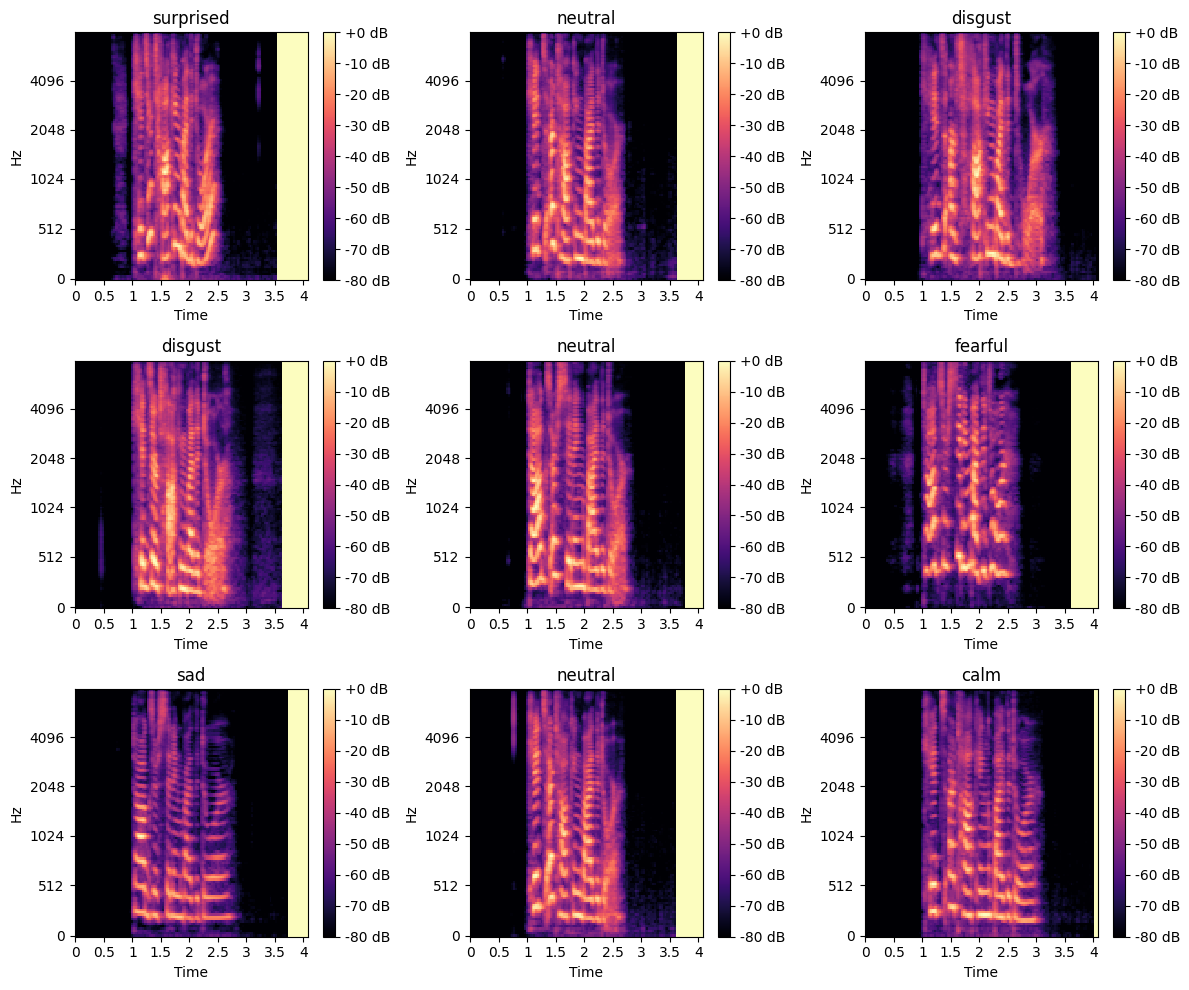

In [97]:
features = (np.array(features))
plt.figure(figsize=(12, 10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    librosa.display.specshow(features[i], sr=16000, x_axis='time', y_axis='mel', cmap='magma')
    plt.title(labels[i])   # Emotion label (like 'happy', 'sad', etc.)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()

plt.show()

In [29]:
X = np.array(features)
X = X[..., np.newaxis]  # add channel dim for CNN

le = LabelEncoder()
y = le.fit_transform(labels)
y = tf.keras.utils.to_categorical(y, num_classes=len(le.classes_))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,216 (430.53 KB)

 Trainable params: 110,216 (430.53 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
X_train.shape

(2304, 128, 128, 1)

In [37]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=300,
    batch_size=32
)

Epoch 1/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5506 - loss: 1.1852 - val_accuracy: 0.5538 - val_loss: 1.1817
Epoch 2/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5593 - loss: 1.1657 - val_accuracy: 0.5087 - val_loss: 1.2437
Epoch 3/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5447 - loss: 1.1695 - val_accuracy: 0.5434 - val_loss: 1.1694
Epoch 4/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5615 - loss: 1.1768 - val_accuracy: 0.5712 - val_loss: 1.1434
Epoch 5/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5685 - loss: 1.1340 - val_accuracy: 0.5677 - val_loss: 1.1235
Epoch 6/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5877 - loss: 1.1161 - val_accuracy: 0.5694 - val_loss: 1.0975
Epoch 7/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5838 - loss: 1.0636 - val_accuracy: 0.5729 - val_loss: 1.1075
Epoch 8/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6091 - loss: 1.0501 - val_accuracy: 0.

In [38]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.3f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9393 - loss: 0.5227
Test Accuracy: 0.938


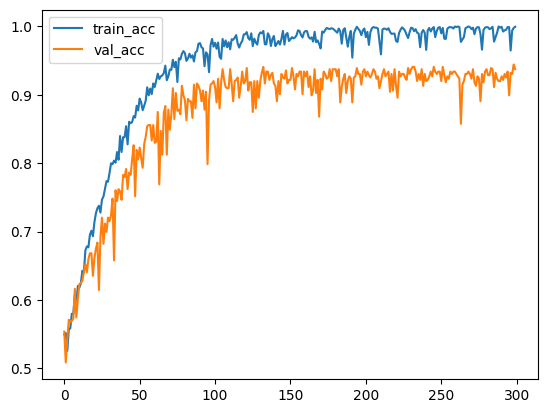

In [39]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [54]:
def predict_emotion(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec = mel_spec[:, :128]
    mel_spec = np.pad(mel_spec, ((0,0),(0,max(0,128 - mel_spec.shape[1]))), mode='constant')
    mel_spec = mel_spec[np.newaxis, ..., np.newaxis]
    pred = model.predict(mel_spec)
    return le.classes_[np.argmax(pred)]

print("Predicted Emotion:", predict_emotion(file_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
Predicted Emotion: disgust


Sample rate: 16000, Audio length: 4.14 seconds


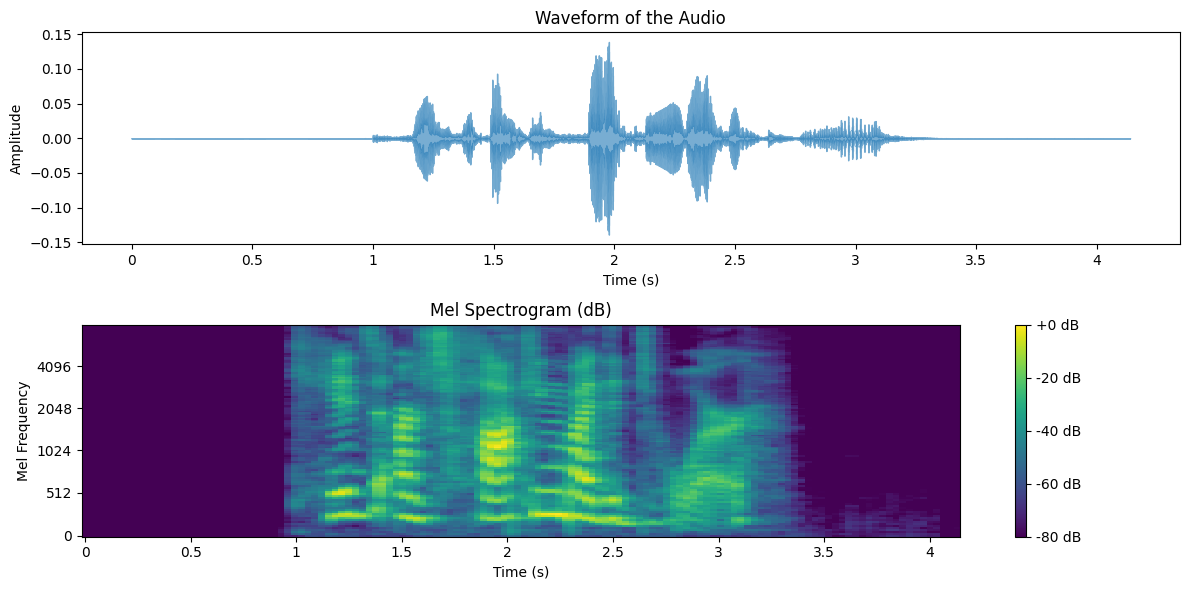

In [67]:
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def visualize_spectrogram(file_path):
    # 1️⃣ Load audio
    y, sr = librosa.load(file_path, sr=16000)
    print(f"Sample rate: {sr}, Audio length: {len(y)/sr:.2f} seconds")

    # 2️⃣ Generate Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # 3️⃣ Plot the waveform (top)
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(y, sr=sr, alpha=0.6)
    plt.title("Waveform of the Audio")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    # 4️⃣ Plot the Mel Spectrogram (bottom)
    plt.subplot(2, 1, 2)
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
    plt.title("Mel Spectrogram (dB)")
    plt.xlabel("Time (s)")
    plt.ylabel("Mel Frequency")
    plt.colorbar(format="%+2.0f dB")

    plt.tight_layout()
    plt.show()
visualize_spectrogram(file_path)

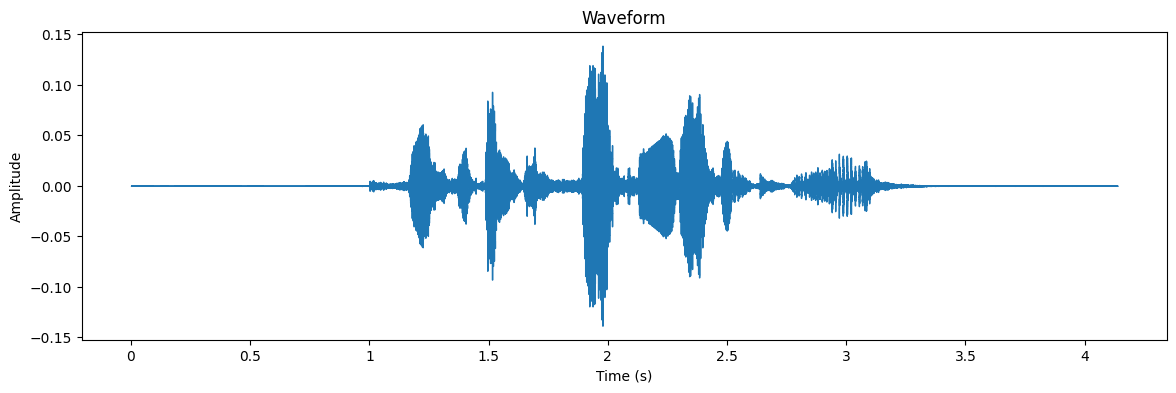

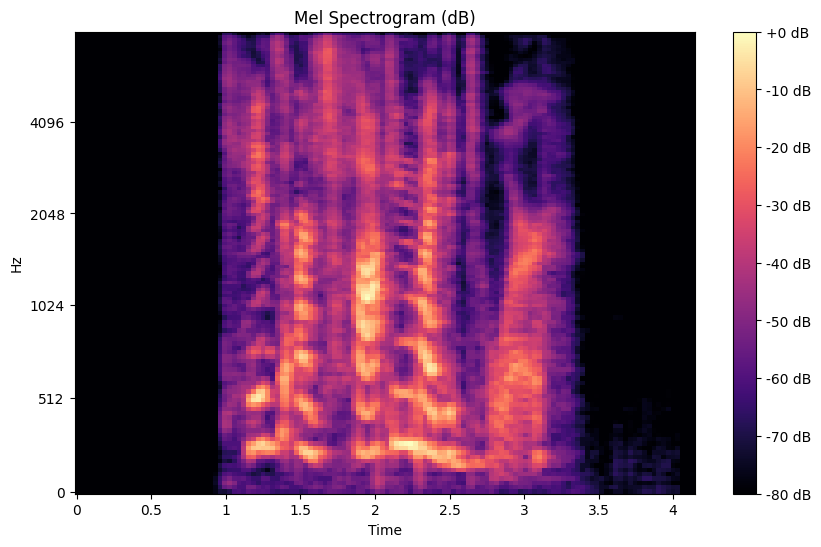

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
🎭 Predicted Emotion: disgust


In [68]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

def visualize_audio(file_path):
    # Load the audio file
    y, sr = librosa.load(file_path, sr=16000)

    # Create the Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Plot waveform
    plt.figure(figsize=(14, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title("Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

    # Plot mel spectrogram
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Mel Spectrogram (dB)")
    plt.show()

    # Predict emotion
    emotion = predict_emotion(file_path)
    print(f"🎭 Predicted Emotion: {emotion}")

# Example
visualize_audio(file_path)


In [72]:
y_pred = model.predict(X_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [74]:
y_pred = np.argmax(y_pred,axis = 1)

In [79]:
y_true = np.argmax(y_test,axis = 1)

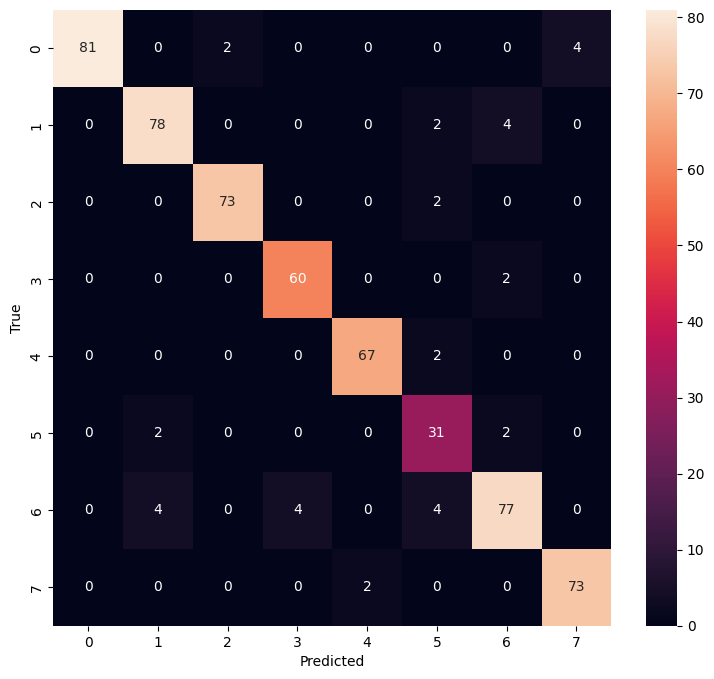

In [81]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(9, 8))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

This is the speach Emotion Project with simple cnn which is slightly overifiting so next we do CRNN for getting some higher accuracy and some good result.